# Cifar-10 이미지 분류v2

In [1]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 전처리

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
X_train.shape, X_test.shape, y_train.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1))

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


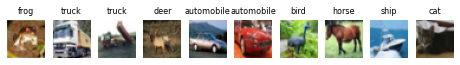

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i]), plt.axis('off')
    plt.title(class_names[y_train[i,0]], fontsize=8)

plt.show()

In [6]:
# X data : 정규화 - 0~1 사이의 실수(float32)로 변환
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype(np.float32) / 255.

In [7]:
# y data : one-hot- encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

- 모델 정의/설정/학습/평가


In [8]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [9]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), activation='relu'),
    Conv2D(32, (3,3), padding='same',activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [10]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001, decay=1e-8), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [11]:
model_path = 'best-cifar10-v2.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 데이터 부풀리기

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,               # set input mean to 0 over the dataset
    samplewise_center=False,                # set each sample mean to 0
    featurewise_std_normalization=False,    # divide inputs by std of dataset
    samplewise_std_normalization=False,     # divide each input by its std
    zca_whitening=False,                    # apply ZCA whitening
    zca_epsilon=1e-06,                      # epsilon for ZCA whitening
    rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.1,                  # randomly shift images horizontally
    height_shift_range=0.1,                 # randomly shift images vertically
    shear_range=0.,                         # set range for random shear
    zoom_range=0.1,                         # set range for random zoom
    channel_shift_range=0.,                 # set range for random channel shifts
    fill_mode='nearest',                    # set mode for filling points outside the input boundaries
    cval=0.,                                # value used for fill_mode = "constant"
    horizontal_flip=True,                   # randomly flip images
    vertical_flip=False,                    # randomly flip images
    rescale=None,                           # set rescaling factor (applied before any other transformation)
    preprocessing_function=None,            # set function that will be applied on each input
    data_format=None,                       # image data format, either "channels_first" or "channels_last"
    validation_split=0.0                    # fraction of images reserved for validation
)
datagen.fit(X_train)

In [18]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32), 
    validation_data=(X_valid, Y_valid),
    epochs=100, verbose=2,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.65479, saving model to best-cifar10-v2.h5
1250/1250 - 33s - loss: 1.8630 - accuracy: 0.3168 - val_loss: 1.6548 - val_accuracy: 0.4131 - 33s/epoch - 27ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 1.65479 to 1.42834, saving model to best-cifar10-v2.h5
1250/1250 - 22s - loss: 1.5935 - accuracy: 0.4168 - val_loss: 1.4283 - val_accuracy: 0.4871 - 22s/epoch - 18ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 1.42834 to 1.29413, saving model to best-cifar10-v2.h5
1250/1250 - 22s - loss: 1.4831 - accuracy: 0.4621 - val_loss: 1.2941 - val_accuracy: 0.5391 - 22s/epoch - 18ms/step
Epoch 4/100

Epoch 00004: val_loss did not improve from 1.29413
1250/1250 - 22s - loss: 1.3944 - accuracy: 0.4998 - val_loss: 1.3643 - val_accuracy: 0.5196 - 22s/epoch - 17ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 1.29413 to 1.24238, saving model to best-cifar10-v2.h5
1250/1250 - 22s - loss: 1.3212 - accuracy: 0.5283 - val_loss

In [19]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6905 - accuracy: 0.7697


[0.6904956698417664, 0.7696999907493591]

- 학습과정 시각화

In [20]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

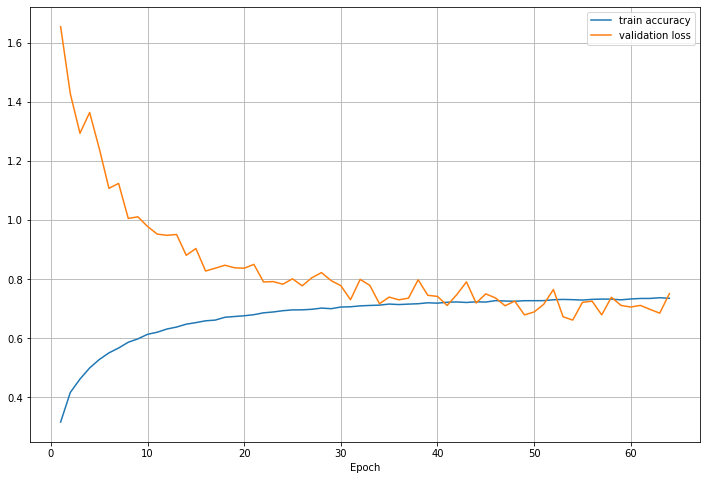

In [21]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.show()